In [ ]:
#https://www.anthropic.com/engineering/building-effective-agents #워크플로: 라우팅

from typing_extensions import TypedDict, Literal
from typing import List
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from langgraph.types import Command
from pydantic import BaseModel

llm = init_chat_model("openai:gpt-4o")

dumb_llm = init_chat_model("openai:gpt-4o-mini")
average_llm = init_chat_model("openai:gpt-3.5-turbo")
smart_llm = init_chat_model("openai:gpt-4o")

def wrap_prompt(prompt:str):
    PROMPT_LANG = "\nAnswer only in fluent and natural Korean, no matter the input language."
    return f"{prompt} {PROMPT_LANG}"


In [2]:
class State(TypedDict):

    question: str
    difficulty: str
    answer: str
    model_used: str

class DifficultyResponse(BaseModel):
    difficulty_level: Literal["easy", "medium", "hard"]


In [3]:
# nodes




def dumb_node(state:State):
    response = dumb_llm.invoke(state["question"])
    return {
        "answer": response.content,
        "model_used": "dumb_llm (gpt-4o-mini)",
    }

def average_node(state:State):
    response = average_llm.invoke(state["question"])
    return {
        "answer": response.content,
        "model_used": "average_llm (gpt-3.5-turbo)",

    }

def smart_node(state:State):
    response = smart_llm.invoke(state["question"])
    return {
        "answer": response.content,
        "model_used": "smart_llm (gpt-4o)",

    }

def assess_difficulty(state:State):
    structured_llm = llm.with_structured_output(DifficultyResponse)

    response = structured_llm.invoke(wrap_prompt(f"""
                                                    이질문의 난이도를 평가해주세요.
                                                    질문: {state['question']}

                                                    - EASY : 간단한 사실, 기본정의, 예/아니오에 해당하는 질문
                                                    - MEDIUM : 설명, 비교, 분석
                                                    - HARD : 여러 단계와 깊은 전문성이 필요한 질문        
                                                """))
    difficulty_level = response.difficulty_level

    if difficulty_level == "easy":
        goto = "dumb_node"
    elif difficulty_level == "medium":
        goto = "average_node"
    elif difficulty_level == "hard":
        goto = "smart_node"
        
    return Command(goto=goto, update={ "difficulty" : difficulty_level})
    
        

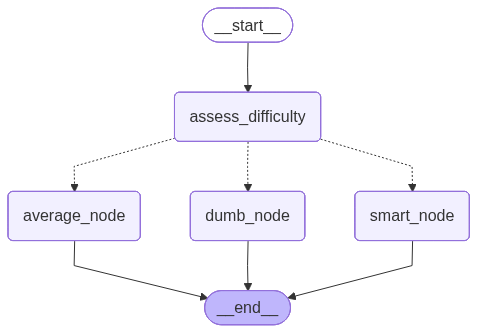

In [4]:
graph_builder = StateGraph(State)

graph_builder.add_node("dumb_node", dumb_node)
graph_builder.add_node("average_node", average_node)
graph_builder.add_node("smart_node", smart_node)
graph_builder.add_node("assess_difficulty", assess_difficulty, destinations=("dumb_node", "average_node", "smart_node"))

graph_builder.add_edge(START, "assess_difficulty")
graph_builder.add_edge("dumb_node", END)
graph_builder.add_edge("average_node", END)
graph_builder.add_edge("assess_difficulty", END)

graph = graph_builder.compile()

graph

In [5]:
graph.invoke({"question": "한국의 수도는?"})

{'question': '한국의 수도는?',
 'difficulty': 'easy',
 'answer': '한국의 수도는 서울입니다.',
 'model_used': 'dumb_llm (gpt-4o-mini)'}